In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/binary_state_kickstarter_projects.csv')
df.head()

,category,subcategory,country,launched,deadline,goal,pledged,backers,state,duration,launch_month,org_state,country_encoded,category_encoded,subcategory_encoded
0,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,0,39,4,Failed,21,5,52
1,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,0,87,4,Failed,21,6,129
2,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,1,8,4,Successful,21,0,70
3,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,1,79,4,Successful,21,13,131
4,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,0,28,4,Failed,21,5,52


In [ ]:
df.columns

In [ ]:
df.info()

In [3]:
# Define feature and target variable
X = df[['goal', 'duration', 'launch_month', 'subcategory_encoded', 'category_encoded', 'country_encoded']]
y = df['state']

X.shape

(372051, 6)

In [ ]:
y.unique()

In [4]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
'''
One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class,
although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples.
This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.
'''

#from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
#smote = SMOTE(random_state=42)
#X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Model performed worse with oversampling

In [5]:
from sklearn.ensemble import GradientBoostingClassifier

# Train the Gradient Boosting Classifier on the balanced dataset
model = GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8)
model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=4, subsample=0.8)

<font size="5">Model evaluation</font>

In [6]:
# Make predictions
y_pred = model.predict(X_test)

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [8]:
# Print evaluation results
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(class_report)

Accuracy: 0.65
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.99      0.78     59646
           1       0.70      0.05      0.09     33367

    accuracy                           0.65     93013
   macro avg       0.67      0.52      0.44     93013
weighted avg       0.67      0.65      0.54     93013



In [9]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# Initialize the Gradient Boosting Classifier
model = GradientBoostingClassifier()

# Initialize Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Train the best estimator
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Evaluate the model
y_pred = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
              precision    recall  f1-score   support

           0       0.72      0.86      0.79     59646
           1       0.62      0.41      0.50     33367

    accuracy                           0.70     93013
   macro avg       0.67      0.64      0.64     93013
weighted avg       0.69      0.70      0.68     93013



In [10]:
conf_matrix = confusion_matrix(y_test, y_pred)

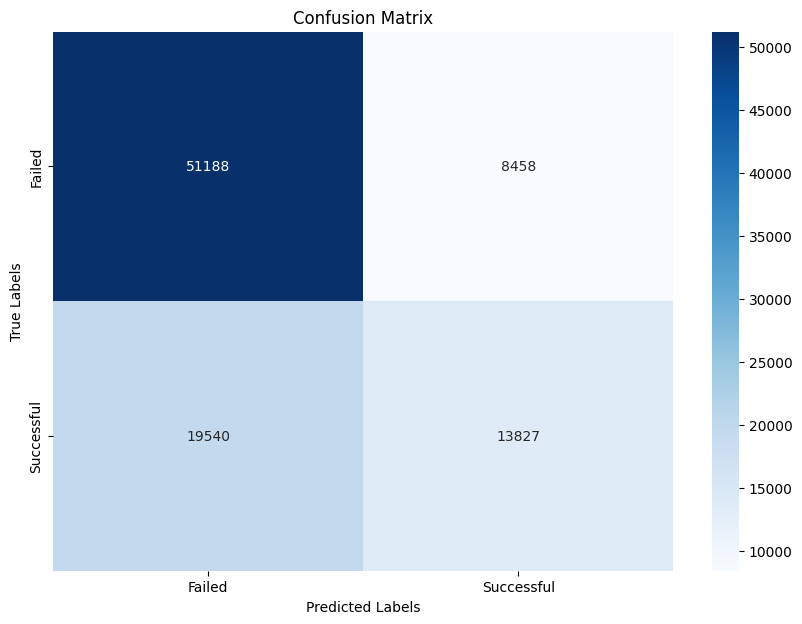

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Failed', 'Successful'], 
            yticklabels=['Failed', 'Successful'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

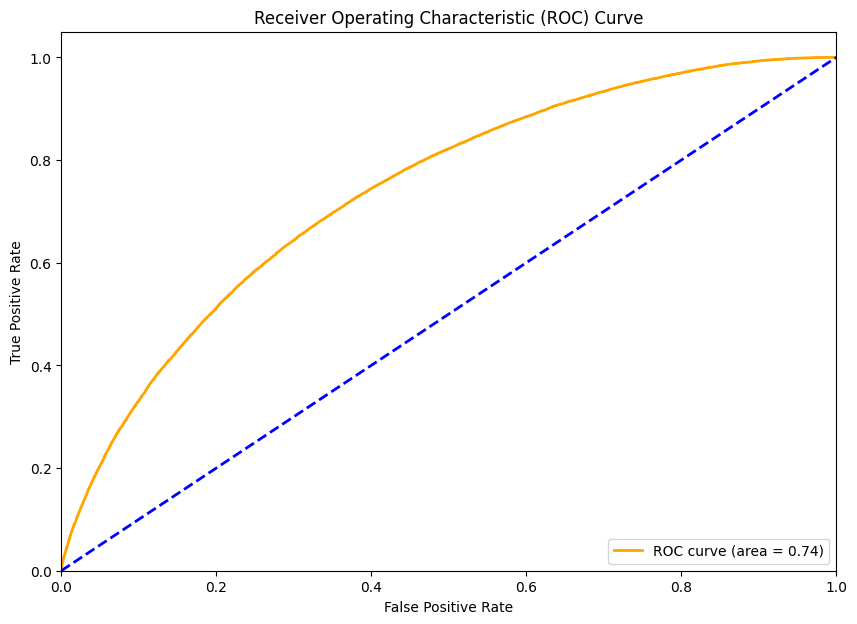

In [13]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Plot ROC Curve
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

<font size="3">Components of the ROC Curve</font>

- True Positive Rate (TPR):
Also known as Recall or Sensitivity.
TPR = TP / (TP + FN)
represents the proportion of actual positives correctly identified by the model.

- False Positive Rate (FPR):
FPR = FP / (FP + TN)
represents the proportion of actual negatives incorrectly identified as positives by the model.
Diagonal Line:

- The diagonal line from (0,0) to (1,1) represents a random classifier with no discriminative power (i.e., it makes random guesses).
Any point above this line indicates a better-than-random performance.

- ROC Curve:
The ROC curve plots TPR (y-axis) against FPR (x-axis) for various threshold values.
The closer the ROC curve is to the top-left corner (TPR = 1, FPR = 0), the better the model.
Area Under the Curve (AUC):

- The AUC quantifies the overall ability of the model to discriminate between positive and negative classes.
AUC ranges from 0 to 1.
AUC of 0.5 indicates a random model, while AUC of 1.0 indicates a perfect model.

<font size="3">Interpretation of the ROC Curve</font>

- Closer to Top-Left Corner:
A ROC curve that bows towards the top-left corner indicates a high-performing model with high sensitivity and specificity.


- AUC Value:
  - 0.90 - 1.00: Excellent model
  - 0.80 - 0.90: Good model
  - 0.70 - 0.80: Fair model
  - 0.60 - 0.70: Poor model
  - 0.50 - 0.60: Fail model (not better than random)


- Comparing Models:
ROC curves and AUC values can be used to compare the performance of different models. The model with the higher AUC is generally considered better.

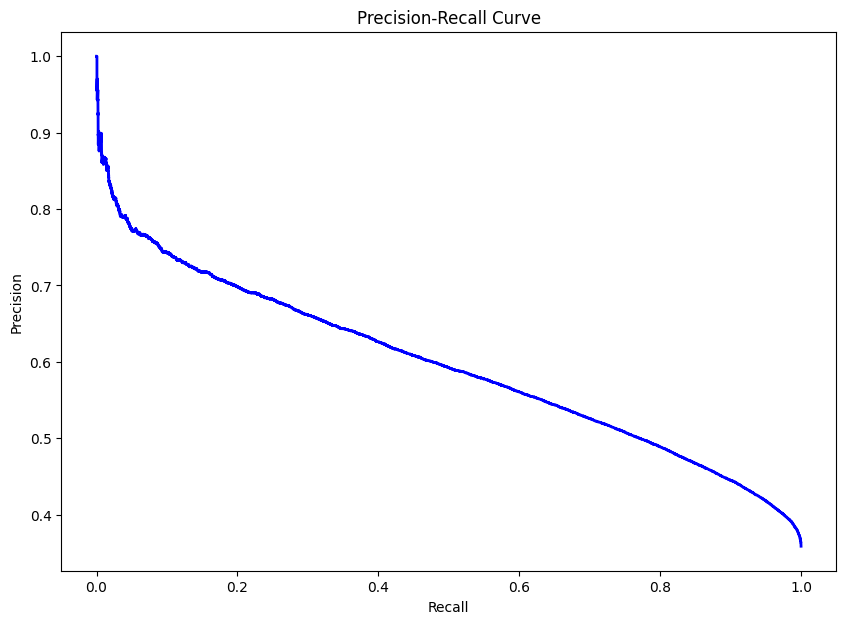

In [14]:
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

<font size="3">Components of the Precision-Recall Curve</font>

- Precision:
Precision (also called Positive Predictive Value) is the ratio of true positive predictions to the total number of positive predictions (both true and false).
Precision = TP / (TP + FP)
High precision indicates a low false positive rate.

- Recall:
Recall (also called Sensitivity or True Positive Rate) is the ratio of true positive predictions to the total number of actual positives.
Recall = TP / (TP + FN)
High recall indicates a low false negative rate.

<font size="3">Interpretation of the Precision-Recall Curve</font>

- Precision-Recall Trade-off:
As recall increases, precision typically decreases, and vice versa.
A high area under the PR curve represents both high precision and high recall.

- Shape of the Curve:
A curve closer to the top-right corner of the plot indicates better performance.
A steep ascent at the beginning followed by a long tail indicates a model that can achieve high precision with good recall up to a point.

- Comparing Models:
Models can be compared based on the shape of their PR curves and the area under the PR curve (AUC-PR).
Higher AUC-PR values indicate better model performance.

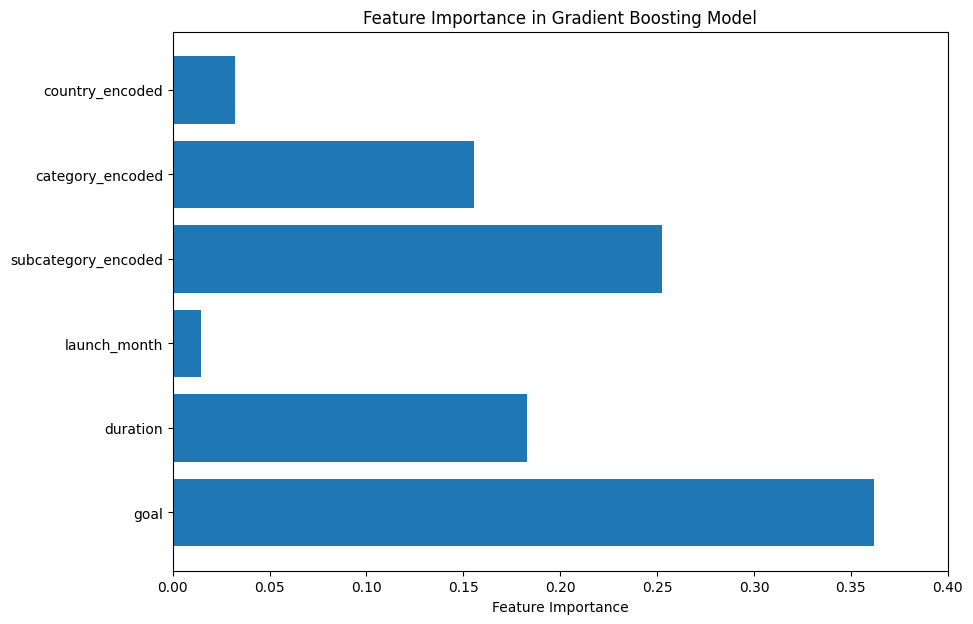

In [18]:
# Plot Feature Importance
importances = best_model.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 7))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting Model')
plt.xlim(0,0.4)
plt.show()